# Overview
In this notebook, I consider the impact of dropping different columns from one-hot-encoded categorical groups when preparing data for Ordinary Least Squares linear regression models.

My initial goal was to answer the following questions:
>- Does it matter which column we drop? In other words, will this choice affect the model's results?
>- If it does matter, how should data scientists select the appropriate column to drop?

My analysis shows that **while the column dropped does not appear to affect a linear regression model's predictive accuracy, it can have a significant impact on the interpretability of the model's coefficients**. 

Data scientists should carefully consider which columns they drop from each category if their goals for analysis include: 
- Using coefficients to infer relative magnitude of predictors' impacts on the target variable (i.e. "Does square footage or the number of bedrooms contribute more to a home's sale price?")
- Accurately understanding how a unit change of predictor variable impacts the target (i.e. "What is the average increase in home sale price for each square foot of living space added?")

Arbitrarily dropping the first column without considering what it represents can make it difficult to interpret the model coefficients accurately. 

Instead, data scientists should drop columns that represent logical baseline reference points, from which the model will assume all included variables to deviate. In some cases a minimum value may be appropriate, in other cases an average value may be appropriate, and in still others the appropriate reference category may depend entirely on the goal of the analysis.

# Introduction
## What is one-hot encoding?
When preparing data for an Ordinary Least Squares linear regression model, it is necessary to dummy, or one-hot encode (OHE), categorical variables into separate columns to represent the non-numerical values as numbers. A categorical variable which represents gender, for instance, will be transformed from a single column:

|Gender|
|---|
|M|
|M|
|F|
|F|
|NB|

into multiple one-hot encoded columns, so named since a value of 1 represents membership in that category and the rest of the category columns being filled with zeros:

|Gender_male|Gender_female|Gender_nonbinary|
|---|---|---|
|1|0|0|
|1|0|0|
|0|1|0|
|0|1|0|
|0|0|1|

## Why drop any columns at all?
When learning about linear regression, students of data science are taught to drop one column from each categorical variable group to act as the reference category, and to avoid the "Dummy Variable Trap:" perfect multicollinearity between the predictors. In our example, we could drop Female, Male, or NonBinary and leave the other two columns in our model.

If the dataset contains multiple categorical variables, one column should be dropped from each group of resulting columns. Throughout this notebook, I will discuss dropping 'a column,' which should be understood to mean one column from each categorical variable's group of one-hot encoded columns.

## Arbitrarily dropping 'first'
Python libraries such as Pandas and sckikit-learn have handy parameters built in to their one-hot-encoding methods which allow us to drop a column from each categorical group. A common approach is to drop whichever column represents the category value name that comes first alpha-numerically in the set, which in our gender example would be Female. 

In fact this is so common that both [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) and [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) have constants you can use to do this so you don't have to figure out the first category.

As a student of data science, it struck me as odd that we should be encouraged to drop the column whose categorical value happens to come first alpha-numerically. 
> If it truly doesn't matter which column was dropped, then why not select one at random, as we could easily ask a computer to do for us?

>If it does matter, why do we assume the first category is best suited? Is this simply for convenience, or is there a logical reason?

To attempt to answer these questions, in this notebook I create an experimental data set for which I have expected results, and test the effect of dropping different columns from the data set before modeling.

# Create Experimental Data Set

I'll create an experimental data set based on home characteristics and sales, where the linear regression model would be trying to predict a home's eventual sale price.

I'll create the following variables:
- **Square Feet of Living Space**: a continuous variable
- **Zip Code**: a categorical variable with a large number of categories (70)
- **Condition**, a categorical variable with a small number of variables (5)
- **Day of the Week (DOTW)**: a capricious variable that will contribute to the price without any particular pattern. I will be able to exclude this from my model to reduce the variability in the target that the model should be able to explain, which will make it somewhat more realistic.

When I model, I'll ask for a y-intercept, which means my model's baseline will assume 0 for continuous variables. 

For this experiment, I'll randomly generate the multiplier coefficients for categorical variables based on a normal distribution, and assign them to the categories such that the 'first' category in each group is the lowest, but not 0.

In [2]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import linregtools

%autoreload 2

## Sq Ft

In [11]:
# Generate sq ft

# Set random seed for reproducability
np.random.seed(5)
df = pd.DataFrame(((np.random.randn(20000)) + 4) * 700, columns=['sqft'])

print(df.head())
print(f"Mean sq ft: {np.mean(df)}")
print(f"Median sq ft: {np.median(df)}")

     sqft
0 3108.86
1 2568.39
2 4501.54
3 2623.54
4 2876.73
Mean sq ft: sqft   2801.13
dtype: float64
Median sq ft: 2803.5581213839223


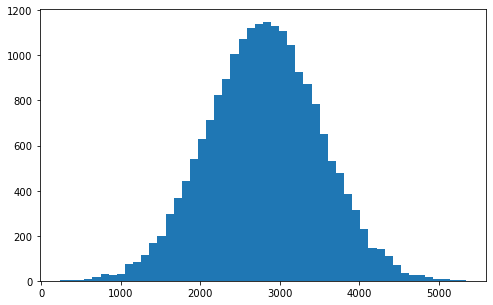

In [12]:
# Plot the sq ft values to confirm their distribution
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['sqft'], bins=50);

## Zip Codes

In [13]:
# Next we'll generate a set of 70 fake zip codes

# Set random seed for reproducability
np.random.seed(5)

zips = np.round(np.random.randn(150),2)
zips = (np.unique(abs(zips)) * 100) + 30000
zips = np.unique(zips)[:70]
np.random.shuffle(zips)

print(zips[:5])
print(f"Unique zip codes: {len(np.unique(zips))}")

[30061. 30043. 30106. 30114. 30089.]
Unique zip codes: 70


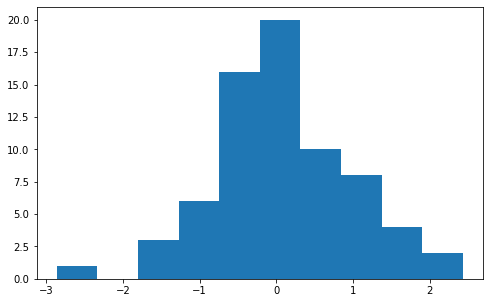

In [14]:
# And assign a random multiplier for price to each zip code.

# Set random seed for reproducability
np.random.seed(5)
zips_x = np.random.randn(70)

# check distribution for zipcode multipliers
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(zips_x);

In [15]:
# combine zipcodes with their multipliers
zips = np.concatenate((zips.reshape(len(zips), 1), 
                       zips_x.reshape(len(zips_x), 1)), axis=1)

# Sort zips so the first will have the lowest multiplier
zips.sort(axis=0)
print(zips[:5])
print(zips[-5:])

[[30000.       -2.86 ]
 [30001.       -1.665]
 [30002.       -1.511]
 [30005.       -1.311]
 [30006.       -1.193]]
[[30106.        1.562]
 [30114.        1.582]
 [30115.        1.857]
 [30116.        2.26 ]
 [30117.        2.431]]


In [16]:
# Turn array into a dataframe and convert zipcode to string
df_zips = pd.DataFrame(zips, columns=['zip','zip_multi'])

df_zips['zip'] = df_zips['zip'].astype(str, copy=False)
df_zips['zip'] = df_zips['zip'].map(lambda x: x[:5])

df_zips.head()

,zip,zip_multi
0,30000,-2.86
1,30001,-1.66
2,30002,-1.51
3,30005,-1.31
4,30006,-1.19


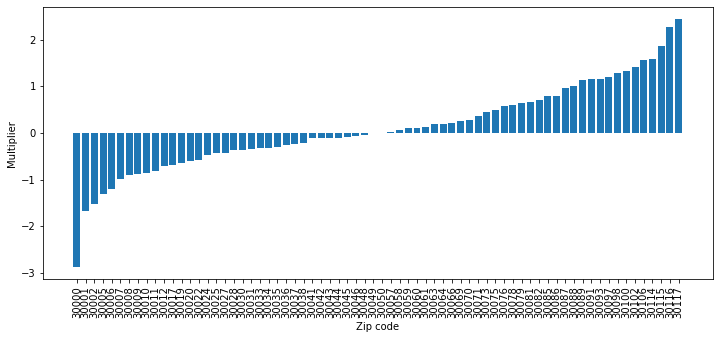

In [17]:
# show distribution of multipliers across zips
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x=df_zips['zip'], height=df_zips['zip_multi'])
ax.set_xlabel('Zip code')

ax.tick_params(axis='x', which='major', rotation=90)

ax.set_ylabel('Multiplier');

When I test dropping the first category of zips (30000), it will represent a zip code with a negative multiplier on the extreme low end, which will not be very representative of the population average, and also will not have an effect of 0.

I'm going to assign zip codes randomly to groups of houses so zip code will be truly independent of sq ft.

In [18]:
# Assign zip codes and multipliers randomly to houses
df = linregtools.assign_cats(df_zips, df, seed=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       20000 non-null  float64
 1   zip        20000 non-null  object 
 2   zip_multi  20000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 468.9+ KB


I want the first zip code that we drop to not only be an outlier in terms of the size of its multiplier, but also in terms of the number of houses in that zip. I want it to be a smaller group size.

In [19]:
# let's check how many houses we randomly assigned to our first zip code 30000
len(df.loc[df['zip'] == '30000'])

349

In [20]:
# how does that compare to the rest?
df['zip'].value_counts(ascending=True)

30043    148
30012    150
30006    151
30079    157
30076    159
        ... 
30044    399
30050    401
30081    408
30069    410
30059    417
Name: zip, Length: 70, dtype: int64

In [21]:
# let's move over a chunk of houses from 30000 to 30043 so 30000 is the smallest
df.loc[df['zip'] == '30043']

,sqft,zip,zip_multi
259,2775.17,30043,-0.10
388,1781.71,30043,-0.10
393,2983.08,30043,-0.10
528,2310.34,30043,-0.10
628,3642.61,30043,-0.10
...,...,...,...
19183,2635.77,30043,-0.10
19334,4274.52,30043,-0.10
19660,3283.43,30043,-0.10
19935,2504.94,30043,-0.10


In [23]:
switch = df.loc[df['zip'] == '30000'][149:].index

df.loc[switch, ['zip']] = '30043'
df.loc[switch, ['zip_multi']] = -0.101068

len(df.loc[df['zip'] == '30000'])

149

## House Condition
This will simulate a rating for the house representing how well it has been maintained, etc. This will be ranked, so houses in below average condition will fetch lower prices, and houses with above average condition will fetch higher prices.

Most houses will receive an average condition, which will have a multiplier of 0. The condition that comes first, 1_poor, will decrease the price.

In [24]:
# Create condition categories and multipliers
conds = [['1_poor', -1.25]
        ,['2_below average', -0.25]
        ,['3_average', 0]
        ,['4_above average', 0.1]
        ,['5_excellent', 0.3]]

df_conds = pd.DataFrame(conds, columns=['condition','condition_multi'])
df_conds.head()

,condition,condition_multi
0,1_poor,-1.25
1,2_below average,-0.25
2,3_average,0.00
3,4_above average,0.10
4,5_excellent,0.30


In [25]:
# create a dictionary to pass with the conditions to make sure the
# average gets applied to the majority of houses
ratio_map = {'1_poor':0.05, '2_below average':0.1, '3_average':0.7,
             '4_above average':0.1, '5_excellent':0.05}

df = linregtools.assign_cats(df_conds, df, ratio_map, 5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             20000 non-null  float64
 1   zip              20000 non-null  object 
 2   zip_multi        20000 non-null  float64
 3   condition        20000 non-null  object 
 4   condition_multi  20000 non-null  float64
dtypes: float64(3), object(2)
memory usage: 781.4+ KB


In [26]:
df['condition'].value_counts()

3_average          14000
4_above average     2000
2_below average     2000
5_excellent         1000
1_poor              1000
Name: condition, dtype: int64

## Confounding variable "Day of the week"
Create a "day of the week" variable representing the day of the week when the buyer viewed the home. 

This isn't intended to be realistic (I don't have reason to believe that the day of the week when someone viewed a home would actually affect its price).

It is intended as a confounding variable that we will include in our calculations to generate price, but that we can exclude from the model to simulate a real-world scenario where price variability cannot be 100% explained by the data we have available. 

In [27]:
dotw = [['Sunday', 0.5]
       ,['Monday', -0.2]
       ,['Tuesday', 0.3]
       ,['Wednesday', -0.1]
       ,['Thursday', 0.25]
       ,['Friday', -0.45]
       ,['Saturday', 0.2]
       ,['Sunday', 0.1]]

df_dotw = pd.DataFrame(dotw, columns=['dotw','dotw_multi'])
df_dotw

,dotw,dotw_multi
0,Sunday,0.50
1,Monday,-0.20
2,Tuesday,0.30
3,Wednesday,-0.10
4,Thursday,0.25
5,Friday,-0.45
6,Saturday,0.20
7,Sunday,0.10


In [29]:
# assign dotw categories randomly to houses
df = linregtools.assign_cats(df_dotw, df, seed=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             20000 non-null  float64
 1   zip              20000 non-null  object 
 2   zip_multi        20000 non-null  float64
 3   condition        20000 non-null  object 
 4   condition_multi  20000 non-null  float64
 5   dotw             20000 non-null  object 
 6   dotw_multi       20000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [30]:
df['dotw'].value_counts()

Sunday       5373
Wednesday    3371
Monday       2975
Tuesday      2674
Thursday     1869
Friday       1869
Saturday     1869
Name: dotw, dtype: int64

In [31]:
df['dotw_multi'].describe()

count   20000.00
mean        0.09
std         0.29
min        -0.45
25%        -0.10
50%         0.10
75%         0.30
max         0.50
Name: dotw_multi, dtype: float64

## Calculate Price

Price will be calculated based on the variables I've created, using values in the multiplier columns against a constant. Since some of my multipliers are negative, I needed to choose an appropriate y-intercept and constant for the multipliers, to make sure I didn't end up with negative or way too small home prices. In testing, I ran a few different versions of the function and tuned these to come up with appropriate numbers.

To keep things simple in this experiment, I'm not going to introduce any multicollinearity, although in real housing data this would likely exist. For instance, average price per square feet might be different in different zip codes, and houses in given zip codes may tend to have more or less square feet than others.

- Baseline (y-intercept) of \\$100,000
- Add \\$100 per sq ft
- Apply multipliers based on zip code, condition, and "day of the week". Since my multipliers were randomly chosen from a normal distribution, I'll multiply them by a base multiplier of 50,000 to get a coefficient that will make a difference in price units.

In [32]:
# Calculate price based on variables
def calc_homeprice(row, base=100000, sqft_x=100, base_multi=50000):
    
    # start with base
    price = base
    
    # for categories, we'll use a baseline of 50,000 and apply the mulipliers
    # to that, since we didn't 
    
    # add sqft
    price += (row['sqft'] * sqft_x)
    # add zip
    price += (row['zip_multi'] * base_multi)
    # add condition
    price += (row['condition_multi'] * base_multi)
    # add dotw
    price += (row['dotw_multi'] * base_multi)
    
    return price
    

In [33]:
df['price'] = df.apply(lambda x : calc_homeprice(x), axis=1)
df.describe()

,sqft,zip_multi,condition_multi,dotw_multi,price
count,20000.00,20000.00,20000.00,20000.00,20000.00
mean,2801.13,0.15,-0.06,0.09,389216.01
std,702.16,0.90,0.29,0.29,85861.15
min,232.89,-2.86,-1.25,-0.45,43625.84
25%,2326.61,-0.36,0.00,-0.10,331564.38
50%,2803.56,0.01,0.00,0.10,387891.56
75%,3278.52,0.71,0.00,0.30,446963.19
max,5339.52,2.43,0.30,0.50,726104.13


I'll admit that a 232 sq ft home is pretty small, and a price of \\$43.6k is pretty low, but in general I'm on board with these sq ft and price statistics for our sample data.

### Calculate expected coefficients for variables
It will be important to understand the expected coefficients for each category, so I can assess each model's accuracy.

Since I'm familiar already with how sklearn's OneHotEncoder class will name the categorical columns, I'll name my columns the same so I can easily compare later.

In [34]:
# create a df of expected coefficients, so we can compare to each model's results
cat_cols = ['zip', 'condition', 'dotw']
base_multi = 50000
coefs_dict = {}

for col in cat_cols:
    
    # get series of unique categorical values and their multipliers
    grouped = df.groupby(col, axis=0, )[col + '_multi'].min()
    
    # rename them to be like what we'll get form OHE
    new_names = [col + '_' + label for label in grouped.index]
    dict_names = dict(zip(grouped.index, new_names))
    grouped.rename(index=dict_names, inplace=True)
    
    # multiply by base
    grouped = grouped * base_multi
    
    # convert to dictionary and merge with existing
    coefs_dict.update(grouped.to_dict())
    
coefs_dict['sqft'] = 100
coefs_dict['y-intercept'] = 100000

#df_ex_coefs = pd.DataFrame(coefs_dict.values(), index=coefs_dict.keys(), 
#                           columns=['expected_coef'])
dict_list = [coefs_dict]

df_ex_coefs = pd.DataFrame(dict_list).transpose()
df_ex_coefs.rename(columns={0: 'expected_coef'}, inplace=True)
df_ex_coefs

,expected_coef
zip_30000,-142984.40
zip_30001,-83239.43
zip_30002,-75558.98
zip_30005,-65538.66
zip_30006,-59638.23
...,...
dotw_Thursday,12500.00
dotw_Tuesday,15000.00
dotw_Wednesday,-5000.00
sqft,100.00


The values above are the coefficients we would hope a good model could produce on data in its original units. 

However, it's common to standardize data before modeling, which basically standardizes the units across variables, making the coefficients more easy to compare to one another. What would our expected coefficients be for standardized data? Can we tell?

I'm going to leave the coefficients of the categorical variables for this purpose as-is, without adjustment.

For sq ft, I believe the average magnitude of its impact on price would be the unit coefficient times number of sq ft in an average house. The mean number of square feet per house is about 2800. At \\$100 per sqft, the sq ft add would about \\$280,000 per house.

I'm not all that confident about my logic here, and there may be a more accurate way to determine what these standardized coefficients should be. However, I do think that overall sq ft should have the largest magnitude of impact on price compared to the variability introduced by the other categorical variables. A sq ft coefficient of 280,000 would be the highest, so I'm comfortable proceeding with this value.

In [35]:
# update standardized coefficient for sqft for later comparison
df_ex_coefs_std = df_ex_coefs.copy()
df_ex_coefs_std.loc['sqft', 'expected_coef'] = 280000
df_ex_coefs_std

,expected_coef
zip_30000,-142984.40
zip_30001,-83239.43
zip_30002,-75558.98
zip_30005,-65538.66
zip_30006,-59638.23
...,...
dotw_Thursday,12500.00
dotw_Tuesday,15000.00
dotw_Wednesday,-5000.00
sqft,280000.00


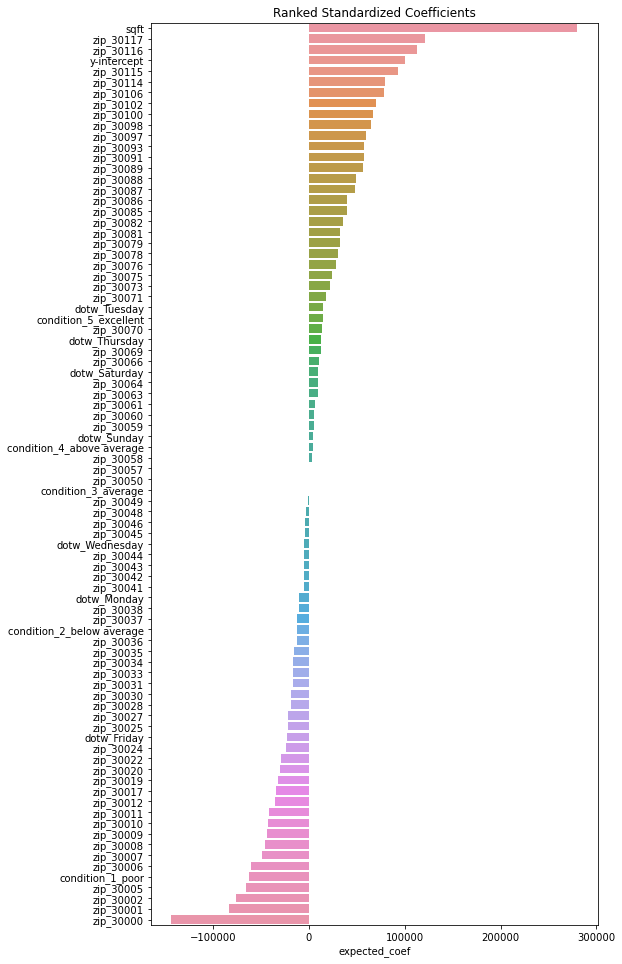

In [36]:
# Get list of categories sorted in alpha order
order = df_ex_coefs_std['expected_coef'].sort_values(ascending=False).index

# plot standardized coefficients in order
h = len(df_ex_coefs_std)
fig, ax = plt.subplots(figsize=(8, (h*0.15)+4))

sns.barplot(data=df_ex_coefs_std, orient='h', x='expected_coef', 
            y=df_ex_coefs_std.index, ax=ax, order=order)
ax.set_title('Ranked Standardized Coefficients');

Great, so I see sq ft has the highest magnitude of impact on price, which is what I think it should be.

### Determine average categories

I specifically engineered the '3_average' condition category to be the average, but I need to figure out what the average zip code and day of the week categories are.

Although I could figure this out by taking the category with the multiplier closest to 0, that approach wouldn't be possible if I didn't know the coefficients, which I wouldn't in a real life scenario. I'm going to decide average category by comparing the mean price within each category to the overall mean price.

In [38]:
# get overall mean price
mean_price = df.price.mean()
print(mean_price)
print('\n')

# get mean price for each zip code
means_per_zip = df.groupby('zip')['price'].mean()

closest = (np.abs(means_per_zip - mean_price)).argmin()
print(f'Zip code with closest mean: {means_per_zip.index[closest]}')
print(f'Mean: {means_per_zip[closest]}')
print('\n')

# get mean price for dotws
means_per_dotw = df.groupby('dotw')['price'].mean()

closest = (np.abs(means_per_dotw - mean_price)).argmin()
print(f'Zip code with closest mean: {means_per_dotw.index[closest]}')
print(f'Mean: {means_per_dotw[closest]}')

389216.0103084257


Zip code with closest mean: 30066
Mean: 389185.41182967776


Zip code with closest mean: Saturday
Mean: 395713.5223757062


OK, so my average categories are going to be a condition of 3, zip code 30066, and 'day of the week' of Saturday.

These are the categories I will test dropped from the model instead of the first. My hypothesis is that dropping them will provide more accurate coefficients.

In [39]:
avg_cats = ['condition_3_average', 'zip_30066', 'dotw_Saturday']
avg_cats

['condition_3_average', 'zip_30066', 'dotw_Saturday']

# Explore Data
Luckily, since we generated this data from scratch, we don't have to worry about data cleaning.

But let's check out the distributions of each variable.

---------------------------------------------------------------------------
Exploring column: price
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: price
---------------------------------------------------------------------------
count    20000.00
mean    389216.01
std      85861.15
min      43625.84
25%     331564.38
50%     387891.56
75%     446963.19
max     726104.13
Name: price, dtype: float64


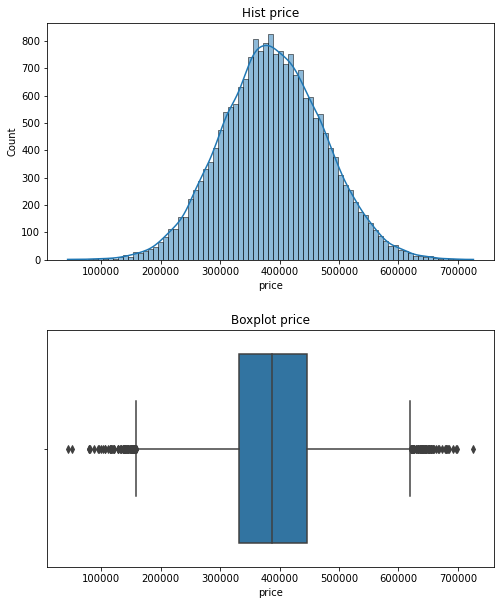


Data IS normal with p-statistic = 0.09689551279019921



,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,price,1.00,continuous,4.67,0.10,True,nan,389216.01,387891.56


In [42]:
linregtools.explore_data('price', df, 'price', plot_v_target=False)

Price, our target variable, is normal. There are some outliers, but we're not going to worry about these for now.

---------------------------------------------------------------------------
Exploring column: sqft
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: sqft
---------------------------------------------------------------------------
count   20000.00
mean     2801.13
std       702.16
min       232.89
25%      2326.61
50%      2803.56
75%      3278.52
max      5339.52
Name: sqft, dtype: float64


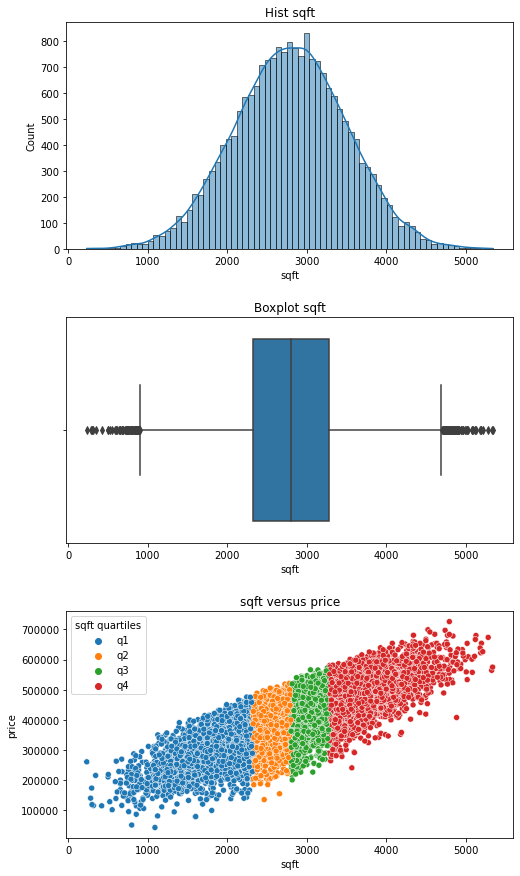


Data IS normal with p-statistic = 0.3749059637869987

---------------------------------------------------------------------------
Exploring column: zip
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: zip
---------------------------------------------------------------------------
30059    417
30069    410
30081    408
30050    401
30044    399
        ... 
30076    159
30079    157
30006    151
30012    150
30000    149
Name: zip, Length: 70, dtype: int64


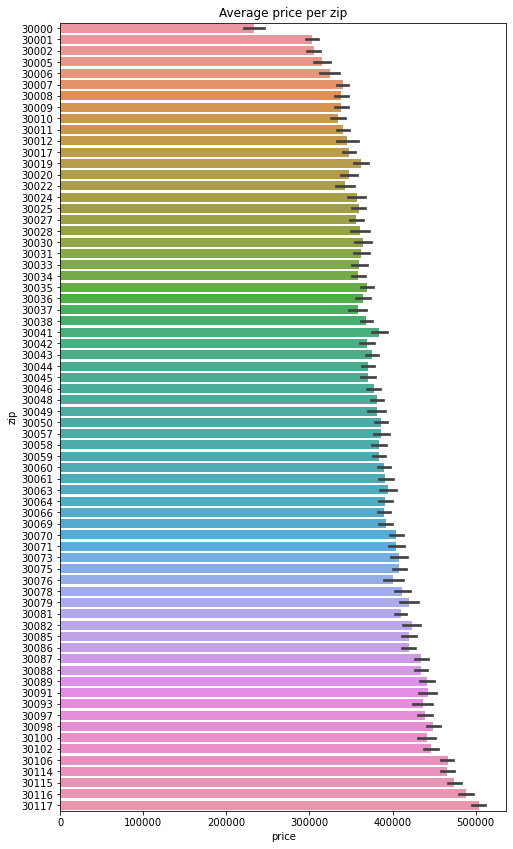

---------------------------------------------------------------------------
Exploring column: condition
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: condition
---------------------------------------------------------------------------
3_average          14000
4_above average     2000
2_below average     2000
5_excellent         1000
1_poor              1000
Name: condition, dtype: int64


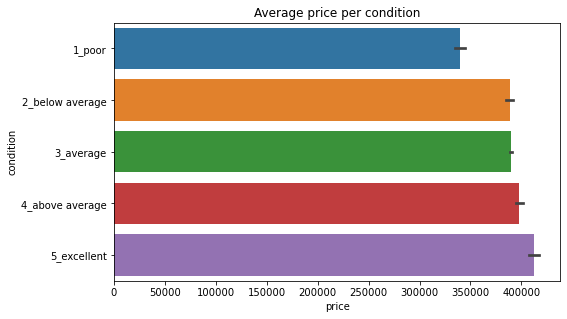

---------------------------------------------------------------------------
Exploring column: dotw
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: dotw
---------------------------------------------------------------------------
Sunday       5373
Wednesday    3371
Monday       2975
Tuesday      2674
Thursday     1869
Friday       1869
Saturday     1869
Name: dotw, dtype: int64


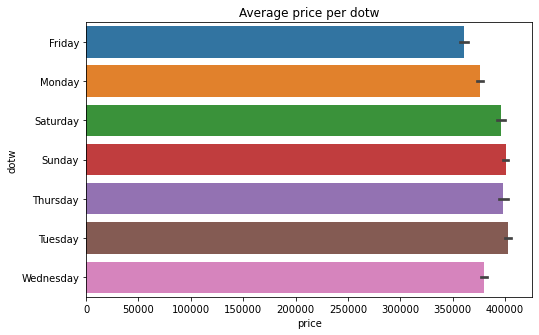

,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,sqft,0.82,continuous,1.96,0.37,True,nan,2801.13,2803.56


In [44]:
ind_vars = ['sqft','zip','condition','dotw']

linregtools.explore_data(ind_vars, df, 'price')

## Summary of Experimental Data
Before we proceed, let's summarize the state of our experimental data:

### Non-Categorical Variables
- We used a baseline price of \\$100,000, so our y-intercept should be 100k.
- We have one continuous independent variable, sq ft, which should have a coefficient of \\$100 per sq ft.

We have three categorical variables: zip, condition, and a confounding variable to add some noise, day of the week (dotw).

### Zip code
- Zip has 70 categories, so a fair amount. 
- Houses were assigned to zip codes randomly, and in fairly even but not totally evenly sized chunks.
- The zip that comes first alphabetically--and will thus be dropped according to convention--is 30000. We have engineered this group to be the smallest (only 149 houses), and with a multiplier (and coefficient) on the lower end, so far from the average.

### Condition
- Condition has only 5 categories, so much fewer.
- We purposefully assigned the majority of houses to a condition of *3_average*, and assigned that group a multiplier of 0. 
- Condition scores of 1, 2, 4, and 5 were assigned to fewer houses. The first category, *1_poor* has a multiplier below average and also much fewer houses than average.

### Day of the Week
- We can model both with dotw and without it to see if the category we drop affects the model to a different degree depending on how much of the variability in target the included variables can explain. 
- Dotw was was assigned randomly. The dotw with mena price closest to average for the population is Saturday, so we'll use that for the average category.


# Modeling

## Map model parameters I want to test

I'm going to run 12 different versions of a model with slightly different parameters for the data.

I'll vary:
- Dropping no categorical variables, dropping the first, and dropping the average. My hypothesis is that dropping different categories won't impact prediction accuracy or performance, but will affect the interpretability of the coefficients.
    - I'm going to test dropping no categorical variables just to prove that the advice to do so is valid. When regularizing, or with other types of models, we often don't need to drop a category, so I think it's worth proving out that it's necessary at all here.
- Keeping in the 'day of the week' (dotw) variable to naturally allow the model to predict more variation, versus excluding dotw and having it act as a confounding variable. This will help me determine if changing how I drop OHE categories impacts model performance differently depending on how much variability my available predictors can explain.
- Standardizing the data or not.

In [45]:
# these are the different model parameters I'll loop through
test_models = {1: {'keep_dotw': True, 'cat_drop': None, 'stand': True},
               2: {'keep_dotw': True, 'cat_drop': 'first', 'stand': True},
               3: {'keep_dotw': True, 'cat_drop': 'avg', 'stand': True},
               4: {'keep_dotw': True, 'cat_drop': None, 'stand': False},
               5: {'keep_dotw': True, 'cat_drop': 'first', 'stand': False},
               6: {'keep_dotw': True, 'cat_drop': 'avg', 'stand': False},
               7: {'keep_dotw': False, 'cat_drop': None, 'stand': True},
               8: {'keep_dotw': False, 'cat_drop': 'first', 'stand': True},
               9: {'keep_dotw': False, 'cat_drop': 'avg', 'stand': True},
               10: {'keep_dotw': False, 'cat_drop': None, 'stand': False},
               11: {'keep_dotw': False, 'cat_drop': 'first', 'stand': False},
               12: {'keep_dotw': False, 'cat_drop': 'avg', 'stand': False}}


## Iterate Models and Save Results

In [47]:
# Run through preprocessing and model fitting on the models with different
# parameters, and save results to a dataframe for the coefficients, and 
# a dataframe for statistics related to accuracy

all_cat_cols = ['zip', 'condition', 'dotw']

df_coefs, df_stats = linregtools.iterate_models_sklearn(
    test_models, df, 'price', ['sqft'], all_cat_cols, avg_cats, 
    random_state=5, verbose=False)

# display results dfs
display(df_coefs)
display(df_stats)

,model_id,y-intercept,sqft,zip_30000,zip_30001,zip_30002,zip_30005,zip_30006,zip_30007,zip_30008,...,condition_3_average,condition_4_above average,condition_5_excellent,dotw_Friday,dotw_Monday,dotw_Saturday,dotw_Sunday,dotw_Thursday,dotw_Tuesday,dotw_Wednesday
0,1,389405.05,70133.63,4826885541855416.00,7037749836267671.00,6475703566027100.00,5749730690782562.00,4805254983424009.00,7595887973142841.00,7391884330184743.00,...,13741410668053096.00,8973893690423098.00,6559017031041776.00,-4044912852283100.50,-4960233140794557.00,-4038399272874222.00,-6183115561858508.00,-4066941353177388.00,-4729327839489217.00,-5208561831216014.00
1,2,389407.35,70133.66,nan,7514.30,7875.79,7905.88,7202.03,12617.09,12819.25,...,27421.05,19234.49,16086.84,nan,4443.25,9426.63,17850.87,10228.21,12746.92,6548.21
2,3,389407.35,70133.66,-13238.59,-11787.99,-9884.99,-7863.78,-5977.24,-8215.99,-7454.31,...,nan,1327.05,2998.29,-9441.83,-7135.17,nan,3417.94,734.96,1707.49,-5609.87
3,4,97063.78,100.00,-148140.92,-88007.13,-79644.02,-70700.66,-63729.22,-54590.75,-50468.60,...,10358.57,14800.54,24089.70,-25038.17,-12562.53,7471.40,15170.18,9988.27,12499.71,-7528.86
4,5,-125697.69,100.00,nan,60133.79,68496.90,77440.26,84411.70,93550.17,97672.32,...,59940.94,64382.92,73672.08,nan,12475.64,32509.57,40208.34,35026.44,37537.88,17509.31
5,6,121220.94,100.00,-154468.12,-94334.33,-85971.22,-77027.86,-70056.42,-60917.95,-56795.80,...,nan,4441.97,13731.13,-32509.57,-20033.93,nan,7698.77,2516.87,5028.31,-15000.26
6,7,389409.46,70392.23,1287532392232381.50,1877262430209843.25,1727341166779981.25,1533693817023451.50,1281762617006743.75,2026141230909490.00,1971724921228261.00,...,-29234211782014608.00,-19091541253836888.00,-13954003529853510.00,nan,nan,nan,nan,nan,nan,nan
7,8,389407.35,70392.89,nan,7301.26,7850.98,8003.20,7244.01,12572.56,12802.40,...,24972.30,18105.75,15476.12,nan,nan,nan,nan,nan,nan,nan
8,9,389407.35,70392.89,-13172.91,-11905.26,-9821.67,-7688.23,-5869.87,-8157.15,-7370.58,...,nan,1797.47,3556.40,nan,nan,nan,nan,nan,nan,nan
9,10,1144218751980.55,100.37,-697037890560.87,-697037832131.93,-697037822279.70,-697037812167.38,-697037805657.16,-697037797340.84,-697037793016.94,...,-447180901349.11,-447180895332.50,-447180885062.05,nan,nan,nan,nan,nan,nan,nan


,model_id,R-sq Train,R-sq Test,RMSE Train,RMSE Test,RSS Train,RSS Test
0,1,1.00,1.00,4825.90,4861.33,349339531770.86,118162431706.11
1,2,1.00,1.00,4825.69,4861.09,349309155602.90,118151030008.34
2,3,1.00,1.00,4825.69,4861.09,349309155602.90,118151030008.34
3,4,1.00,1.00,4825.69,4861.09,349309155602.90,118151030008.33
4,5,1.00,1.00,4825.69,4861.09,349309155602.90,118151030008.35
5,6,1.00,1.00,4825.69,4861.09,349309155602.90,118151030008.35
6,7,0.97,0.97,14298.25,14365.17,3066599781550.65,1031790553536.02
7,8,0.97,0.97,14289.61,14360.42,3062892922873.32,1031108848099.28
8,9,0.97,0.97,14289.61,14360.42,3062892922873.32,1031108848099.28
9,10,0.97,0.97,14289.61,14360.42,3062892922774.08,1031108850146.82


# Accuracy Interpretation
In terms of accuracy (the second df), I see that the first 6 models are pretty similar, and the last 6 models are pretty similar.

The first 6 models are more accurate than the last 6.

Models 1-6 included all the independent variables I created, and models 7-12 did not include 'day of the week' so that it acted as a confounding variable. It makes sense that the last 6 models would have larger errors and be slightly less accurate, since they didn't include all the variables that we engineered to affect price.

There is also a SLIGHT variation between model 1 and 2-5, and model 6 and 7-12. These represent the models for which I standardized the data, and didn't drop any of the categorical variables during OHE. I really don't see any difference between the versions of the models where I dropped the first, or average category.

# Coefficient Interpretation
In the first df, I see that the coefficients change quite a lot for each model. I don't think I'll be able to eyeball the differences between all 12 models this way, so I'll take some time to single out different groups to compare them.

## Calculate difference from expected
Since some of these numbers are quite large, it will be useful to calculate the difference between the expected coefficient for each variable, and what each model came up with. 

Since we have a lot of zip codes and it will be difficult to assess the coefficient differences for each zip, I'll also calculate a mean difference and mean absolute difference for each category to simplify my initial interpretation.

In [51]:
avg_diffs = []

std_models = [1, 2, 3, 7, 8, 9]

# loop through models
# Note that this uses the non-standardized expected coefficiens df
# since the standardized one is the same except for sq ft, I adjusted sq ft
# manually
for i in range(1, 13):
    diffs = {'model_id': i}
    
    # get row from df and transpose it
    coefs = df_coefs.loc[df_coefs['model_id'] == i].transpose()
    coefs.drop(labels=['model_id'], inplace=True)
    coefs.rename(columns={i-1:'model'}, inplace=True)
    
    # concatenate with expected coefs so we can subtract where coefs exist
    coefs = pd.concat([coefs, df_ex_coefs], axis=1)
    #print(coefs.head())
    
    # calculate the difference between mode coef and expected
    coefs['diff'] = coefs.apply((lambda x: x[1] - x[0]), axis=1)
    coefs['abs_diff'] = coefs.apply((lambda x: abs(x[1] - x[0])), axis=1)
    
    # get average difference per categorical group
    diffs['y-intercept_diff'] = coefs.at['y-intercept','diff']
    
    # make an expected coefficient adjustment for sq ft for standardized models
    if i in std_models:
        diffs['sqft_diff'] = 280000 - coefs.at['sqft','model'] 
    else:
        diffs['sqft_diff'] = coefs.at['sqft','diff']
    
    for cat in ['zip', 'condition', 'dotw']:
        diffs[cat + '_meandiff'] = coefs.filter(like=cat, axis=0)['diff'].mean()
        diffs[cat + '_meanabsdiff'] = coefs.filter(like=cat, axis=0)['abs_diff'].mean()
    
    avg_diffs.append(diffs)
    
df_diffs = pd.DataFrame(avg_diffs)

In [52]:
df_diffs

,model_id,y-intercept_diff,sqft_diff,zip_meandiff,zip_meanabsdiff,condition_meandiff,condition_meanabsdiff,dotw_meandiff,dotw_meanabsdiff
0,1,-289405.05,209866.37,-6618799700260097.00,6618799700260097.00,-8958181509176136.00,8958181509176136.00,4747355978814001.00,4747355978814001.00
1,2,-289407.35,209866.34,-10639.93,32610.11,-17535.36,17535.36,-5624.02,7323.43
2,3,-289407.35,209866.34,5543.84,31141.05,-10815.24,18652.57,1887.75,7195.41
3,4,2936.22,-0.00,5044.98,5044.98,-11000.00,11000.00,714.29,3620.05
4,5,225697.69,-0.00,-143097.56,143097.56,-60102.97,60102.97,-24627.86,24627.86
5,6,-21220.94,-0.00,11376.66,11376.66,-801.79,1715.24,7883.30,8782.89
6,7,-289409.46,209607.77,-1765510894743630.50,1765510894743630.50,19058114319328844.00,19058114319328844.00,nan,nan
7,8,-289407.35,209607.11,-10532.47,32582.86,-16431.76,16431.76,nan,nan
8,9,-289407.35,209607.11,5559.92,31156.83,-11707.10,19030.17,nan,nan
9,10,-1144218651980.55,-0.37,697037748360.22,697037748360.22,447180897891.99,447180897891.99,nan,nan


In [53]:
# Add model params into diff dataframe

def map_model_params(x, key, param_dict=test_models):
    val = param_dict[x][key]
    val = 'None' if val is None else val
    return val 

df_diffs['Included dotw'] = df_diffs['model_id'].map(
    lambda x : map_model_params(x, 'keep_dotw'))
df_diffs['Standardized Data'] = df_diffs['model_id'].map(
    lambda x : map_model_params(x, 'stand'))
df_diffs['Category Dropped'] = df_diffs['model_id'].map(
    lambda x : map_model_params(x, 'cat_drop'))

df_diffs

,model_id,y-intercept_diff,sqft_diff,zip_meandiff,zip_meanabsdiff,condition_meandiff,condition_meanabsdiff,dotw_meandiff,dotw_meanabsdiff,Included dotw,Standardized Data,Category Dropped
0,1,-289405.05,209866.37,-6618799700260097.00,6618799700260097.00,-8958181509176136.00,8958181509176136.00,4747355978814001.00,4747355978814001.00,True,True,None
1,2,-289407.35,209866.34,-10639.93,32610.11,-17535.36,17535.36,-5624.02,7323.43,True,True,first
2,3,-289407.35,209866.34,5543.84,31141.05,-10815.24,18652.57,1887.75,7195.41,True,True,avg
3,4,2936.22,-0.00,5044.98,5044.98,-11000.00,11000.00,714.29,3620.05,True,False,None
4,5,225697.69,-0.00,-143097.56,143097.56,-60102.97,60102.97,-24627.86,24627.86,True,False,first
5,6,-21220.94,-0.00,11376.66,11376.66,-801.79,1715.24,7883.30,8782.89,True,False,avg
6,7,-289409.46,209607.77,-1765510894743630.50,1765510894743630.50,19058114319328844.00,19058114319328844.00,nan,nan,False,True,None
7,8,-289407.35,209607.11,-10532.47,32582.86,-16431.76,16431.76,nan,nan,False,True,first
8,9,-289407.35,209607.11,5559.92,31156.83,-11707.10,19030.17,nan,nan,False,True,avg
9,10,-1144218651980.55,-0.37,697037748360.22,697037748360.22,447180897891.99,447180897891.99,nan,nan,False,False,None


## No categories dropped

In [54]:
cols = ['model_id', 'y-intercept_diff', 'sqft_diff', 'zip_meandiff', 
        'condition_meandiff', 'Included dotw', 'Standardized Data']
df_diffs.loc[df_diffs['Category Dropped'] == 'None', cols]


,model_id,y-intercept_diff,sqft_diff,zip_meandiff,condition_meandiff,Included dotw,Standardized Data
0,1,-289405.05,209866.37,-6618799700260097.00,-8958181509176136.00,True,True
3,4,2936.22,-0.00,5044.98,-11000.00,True,False
6,7,-289409.46,209607.77,-1765510894743630.50,19058114319328844.00,False,True
9,10,-1144218651980.55,-0.37,697037748360.22,447180897891.99,False,False


When we didn't drop any categories (which I did just to see what would happen) the coefficients were all over the place.

The best performer was model 4 when I didn't standardize and also included the confounding variable. However, it's very unlikely in a real world scenario that we would have ALL the variables that explain the variability in the data, so I think in general I can conclude that the choice to not drop a category is unlikely to yield results that will be useful for interpretation.

## Categories dropped, standardized data

In [56]:
cols = ['model_id', 'y-intercept_diff', 'sqft_diff', 'zip_meandiff', 
        'condition_meandiff', 'Included dotw', 'Standardized Data', 
        'Category Dropped']
df_diffs.loc[(df_diffs['Category Dropped'] != 'None') & 
             (df_diffs['Standardized Data'] == True)
             , cols]

,model_id,y-intercept_diff,sqft_diff,zip_meandiff,condition_meandiff,Included dotw,Standardized Data,Category Dropped
1,2,-289407.35,209866.34,-10639.93,-17535.36,True,True,first
2,3,-289407.35,209866.34,5543.84,-10815.24,True,True,avg
7,8,-289407.35,209607.11,-10532.47,-16431.76,False,True,first
8,9,-289407.35,209607.11,5559.92,-11707.10,False,True,avg


Focusing on the scenarios where we did drop a category, there wasn't an appreciable difference in whether the confounding variable was included or not.

In other words, the first two rows here look pretty much the same as the last two.

I'm not too surprised that the coefficients aren't very accurate with the standardized data. This could very well be due to the way I calculated my expected coefficients for standardized data, which may not be accurate. I'll ultimately be focusing less on the accuracy of the coefficients of the standardized data, and more on how their magnitudes rank compared to each other.

In [57]:
# top 25 expected standardized coefficients
df_ex_coefs_std['expected_coef'].sort_values(ascending=False)[:30]

sqft                    280000.00
zip_30117               121538.56
zip_30116               113005.34
y-intercept             100000.00
zip_30115                92866.55
zip_30114                79124.06
zip_30106                78076.61
zip_30102                70669.90
zip_30100                66742.43
zip_30098                64598.17
zip_30097                59453.04
zip_30093                57610.24
zip_30091                57569.55
zip_30089                56967.15
zip_30088                49821.99
zip_30087                48608.97
zip_30086                39652.67
zip_30085                39468.32
zip_30082                35621.06
zip_30081                32830.97
zip_30079                32242.38
zip_30078                30173.58
zip_30076                28406.64
zip_30075                24722.02
zip_30073                22061.37
zip_30071                17771.92
dotw_Tuesday             15000.00
condition_5_excellent    15000.00
zip_30070                13480.62
dotw_Thursday 

In [59]:
# filter out coefficients for models where we standardized data, and 
# did not include confounding variable (more realistic)
std_test_coefs = df_coefs.filter(items=[7, 8], axis=0).transpose()
std_test_coefs.rename(columns={7:'Dropped First', 8:'Dropped Avg'}, inplace=True)
std_test_coefs.drop(index='model_id', inplace=True)
std_test_coefs.dropna(axis=0, how='all', inplace=True)
std_test_coefs


,Dropped First,Dropped Avg
y-intercept,389407.35,389407.35
sqft,70392.89,70392.89
zip_30000,nan,-13172.91
zip_30001,7301.26,-11905.26
zip_30002,7850.98,-9821.67
...,...,...
condition_1_poor,nan,-11904.71
condition_2_below average,14672.88,-1620.74
condition_3_average,24972.30,nan
condition_4_above average,18105.75,1797.47


In [60]:
# top 25 standardized coefficients when first cat dropped
std_test_coefs['Dropped First'].sort_values(ascending=False)[:25]

y-intercept           389407.35
sqft                   70392.89
zip_30116              33546.87
zip_30117              32654.24
zip_30115              30327.23
zip_30106              29473.38
zip_30114              28496.94
zip_30089              26618.40
zip_30098              26462.93
zip_30102              25660.97
zip_30081              25146.20
zip_30088              25113.26
zip_30097              25103.59
condition_3_average    24972.30
zip_30087              24070.12
zip_30100              22975.75
zip_30086              22286.16
zip_30075              22150.99
zip_30085              21639.97
zip_30069              21308.85
zip_30059              21204.61
zip_30050              20248.59
zip_30060              20038.42
zip_30070              19876.38
zip_30066              19792.45
Name: Dropped First, dtype: float64

Looking at the coefficients when I dropped the first column, sqft is the highest ranked predictor, and higher number zip codes come next, so that matches expected pretty well. 

But in my test, average condition makes it into the top 25, which isn't quite right. Especially since higher condition scores of 4 or 5 aren't in the top 25, which means in the test model they must be ranked below the average score of 3.

In [61]:
# top 25 standardized coefficients when avg cat dropped
std_test_coefs['Dropped Avg'].sort_values(ascending=False)[:25]

y-intercept                 389407.35
sqft                         70392.89
zip_30117                    13527.30
zip_30116                    13298.71
zip_30115                    10381.63
zip_30106                     8964.41
zip_30114                     8781.54
zip_30102                     7350.04
zip_30098                     6824.90
zip_30100                     6148.31
zip_30089                     6109.43
zip_30097                     5976.64
zip_30088                     5015.77
zip_30087                     4744.90
zip_30091                     4290.42
zip_30093                     4028.08
condition_5_excellent         3556.40
zip_30086                     3319.44
zip_30085                     3245.71
zip_30081                     3176.40
zip_30082                     2439.55
zip_30078                     1946.08
condition_4_above average     1797.47
zip_30079                     1751.39
zip_30075                     1568.15
Name: Dropped Avg, dtype: float64

The top 25 coefficients look more reasonable in the model where I dropped the average cats. The order doesn't exactly match expected, but it's much closer. Condition 5 comes above condition 4.

## Categories dropped, original units

In [64]:
df_diffs.loc[(df_diffs['Category Dropped'] != 'None') & 
             (df_diffs['Standardized Data'] == False) 
             #& (df_diffs['Included dotw'] == False)
             , cols]

,model_id,y-intercept_diff,sqft_diff,zip_meandiff,condition_meandiff,Included dotw,Standardized Data,Category Dropped
4,5,225697.69,-0.00,-143097.56,-60102.97,True,False,first
5,6,-21220.94,-0.00,11376.66,-801.79,True,False,avg
10,11,194517.54,-0.37,-142189.29,-56931.55,False,False,first
11,12,-13772.32,-0.37,11507.45,-4321.41,False,False,avg


With unstandardized data, dropping the average category (second and fourth rows) yielded mean category coefficients that are much closer to expected, regardless of whether we included the confounding variable or not.

# Conclusions

## Category dropped does not affect a model's accuracy

In the first 6 models, I kept in the 'day of the week' variable, and in the last 6 I left it out, so it would act as a confounding variable.

Although other aspects of how the data was processed were varied, such as whether the data was standardized and which category was dropped, these factors do not have an appreciable affect on R-Squared, Root Mean Squared Errors, or Residual Sum of Squares. The models which were run without the 'day of the week' variable were slightly less accurate than those that included it, which makes intuitive sense.

Interestingly, even if I didn't drop any variable, the predictions were still pretty accurate. My intuition says this might not be the case with data that explains less of the target's variability and is more realistic--even leaving out dotw, the R-Squared was still an absurdly high 0.97.

I conclude that changing the category column which is dropped from modeling does not affect either the amount of variability that the model explains, or the accuracy of the model's predictions.

In [65]:
df_stats['Included dotw'] = df_stats['model_id'].map(
    lambda x : map_model_params(x, 'keep_dotw'))
df_stats['Standardized Data'] = df_stats['model_id'].map(
    lambda x : map_model_params(x, 'stand'))
df_stats['Category Dropped'] = df_stats['model_id'].map(
    lambda x : map_model_params(x, 'cat_drop'))


display(df_stats.drop(columns=['model_id', 'RSS Train', 'RSS Test']))

,R-sq Train,R-sq Test,RMSE Train,RMSE Test,Included dotw,Standardized Data,Category Dropped
0,1.00,1.00,4825.90,4861.33,True,True,None
1,1.00,1.00,4825.69,4861.09,True,True,first
2,1.00,1.00,4825.69,4861.09,True,True,avg
3,1.00,1.00,4825.69,4861.09,True,False,None
4,1.00,1.00,4825.69,4861.09,True,False,first
5,1.00,1.00,4825.69,4861.09,True,False,avg
6,0.97,0.97,14298.25,14365.17,False,True,None
7,0.97,0.97,14289.61,14360.42,False,True,first
8,0.97,0.97,14289.61,14360.42,False,True,avg
9,0.97,0.97,14289.61,14360.42,False,False,None


## Category dropped DOES have an impact on interpretability of coefficients

### Ranking Standardized Coefficients

One way we might want to be able to interpret coefficients is to rank them  to compare the magnitude of their effects on the target. The goal would be to determine which variables increase or decrease the target to a greater degree.

We got some strange results when the first category was dropped, especially with condition. Average condition was set up to actually add nothing to price, where above average and excellent were set up to be additive. 

In the model where the first category, poor, was dropped, average condition is ranked as having a higher impact than above average or excellent.

In the model where the average category was dropped, although the ranking still doesn't exactly match our expected (which I wasn't highly confident in calculating), the conditions are in the right order.

In [66]:
# do some renaming to make charts look nicer
std_test_coefs['Expected'] = df_ex_coefs_std['expected_coef']
std_test_coefs.drop(index=['y-intercept', 'sqft'], inplace=True)
std_test_coefs = std_test_coefs.sort_values(['Expected'], ascending=False)

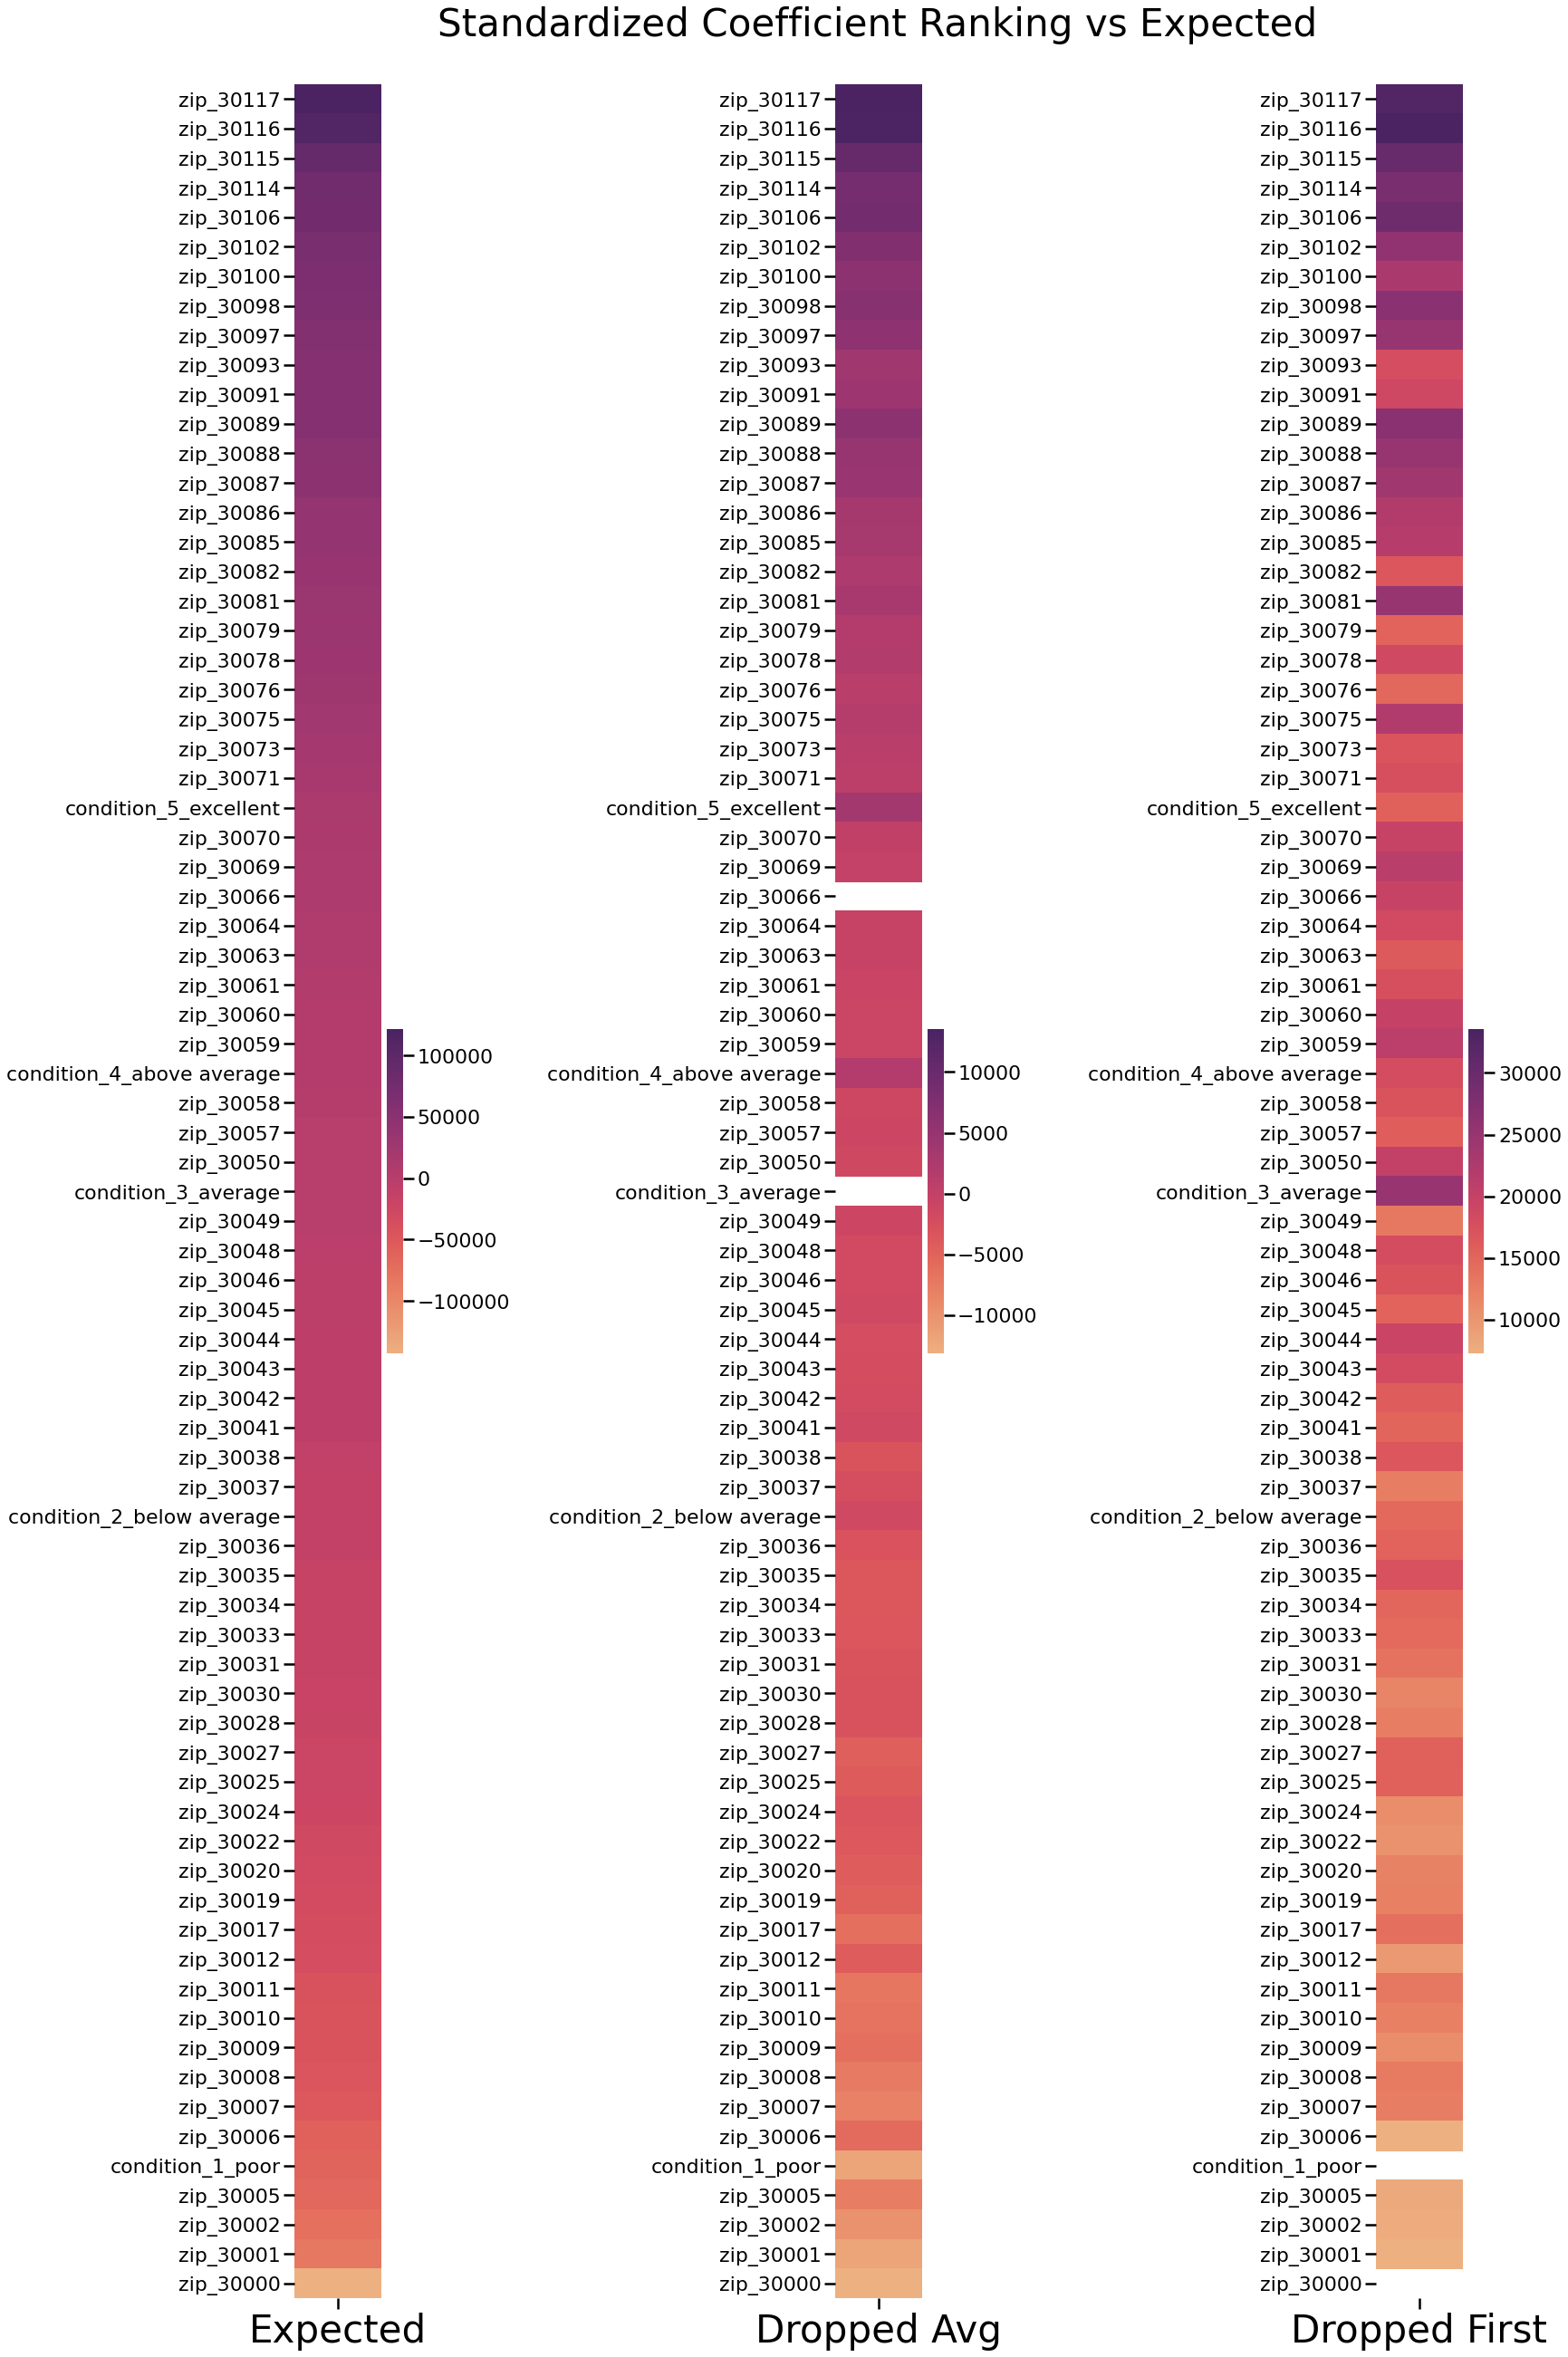

In [82]:
sns.set_context('poster')
    
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(20, 40), ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=4, hspace=2)

sns.heatmap(std_test_coefs[['Expected']], cmap='flare', ax=ax1)
sns.heatmap(std_test_coefs[['Dropped Avg']], cmap='flare', ax=ax2)
sns.heatmap(std_test_coefs[['Dropped First']], cmap='flare', ax=ax3)

for ax_f in [ax1, ax2, ax3]:
    ax_f.set_xticklabels(ax_f.get_xticklabels(), fontsize=42)

# great subplot title formatting tips used below from:
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
st = fig.suptitle("Standardized Coefficient Ranking vs Expected", fontsize=42)
# shift subplots down:
st.set_y(0.90)
fig.subplots_adjust(top=0.87);

Note that the color scales here don't share the same absolute values, since both of our test models differed quite a bit from the expected.

However, if we sort the variables (y-axis) for all three heatmaps to be the order of the expected coefficients, we can see that the color order for the Dropped Avg model is much closer to expected.

Let's zoom in on the condition categorical variables, since those seem to have the most discrepancy. 

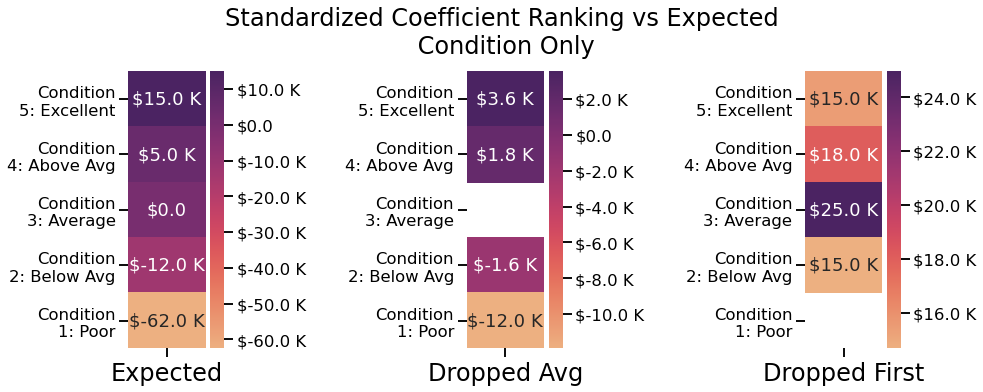

In [86]:
sns.set_context('talk')

mapper = {'condition_5_excellent': 'Condition\n5: Excellent',
          'condition_4_above average': 'Condition\n4: Above Avg',
          'condition_3_average': 'Condition\n3: Average',
          'condition_2_below average': 'Condition\n2: Below Avg',
          'condition_1_poor': 'Condition\n1: Poor',
         }

fig, [ax1, ax2, ax3] = plt.subplots(figsize=(12, 6), ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=2.5)

exp = std_test_coefs[['Expected']].filter(like='condition', axis=0)
exp.rename(mapper=mapper, inplace=True)
avg = std_test_coefs[['Dropped Avg']].filter(like='condition', axis=0)
avg.rename(mapper=mapper, inplace=True)
first = std_test_coefs[['Dropped First']].filter(like='condition', axis=0)
first.rename(mapper=mapper, inplace=True)

sns.heatmap(exp, cmap='flare', ax=ax1, annot=True)
sns.heatmap(avg, cmap='flare', ax=ax2, annot=True)
sns.heatmap(first, cmap='flare', ax=ax3, annot=True)

# code adapted from https://stackoverflow.com/questions/55007525/add-comma-separator-to-seaborn-heatmap-using-set-text-from-matplotlib-and-keep-d
for ax_f in [ax1, ax2, ax3]:
    for t in ax_f.texts:
        t.set_text(linregtools.currency(float(t.get_text())))
    # code adapted from https://stackoverflow.com/questions/34820239/seaborn-heatmap-colorbar-label-as-percentage
    cbar = ax_f.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(linregtools.currency)
    ax_f.set_yticklabels(ax_f.get_yticklabels(), rotation = 0)
    ax_f.set_xticklabels(ax_f.get_xticklabels(), fontsize=24)
    
# great subplot title formatting tips used below from:
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
st = fig.suptitle("Standardized Coefficient Ranking vs Expected\n Condition Only", fontsize=24)
# shift subplots down:
st.set_y(0.90)
fig.subplots_adjust(top=0.75);

Here we can see more clearly that conditions are not ranked as we would expect in the model where we dropped first. 

We would expect the magnitude of impact on price to go from 5 as highest, down to 1 as lowest. The model where we dropped average follows this, while the dropped first model actually ranks an average condition of 3 first.

Since data scientists would likely have some intuition about a categorical value with values like 'excellent', 'above average', and 'average,' I would hope that these results would give pause and cause most to re-evaluate. But if we had category values like School Attended, for instance, we may not have an intuitive sense for what order we would expect. 

If we were to take the results at face value and assert that condition 3 has the largest positive impact on price, we would be incorrect and there would be no easy way to tell.

### Accurate Unstandardized Coefficients

We also might be interested in using the coefficients in original units, from the model where we did not standardize the data, to understand how the target variable changes per unit of each predictor variable. For instance, we would want to be able to use the coefficient associated with sq ft to say "for each sq ft, the price goes up by an estimated \\$100."


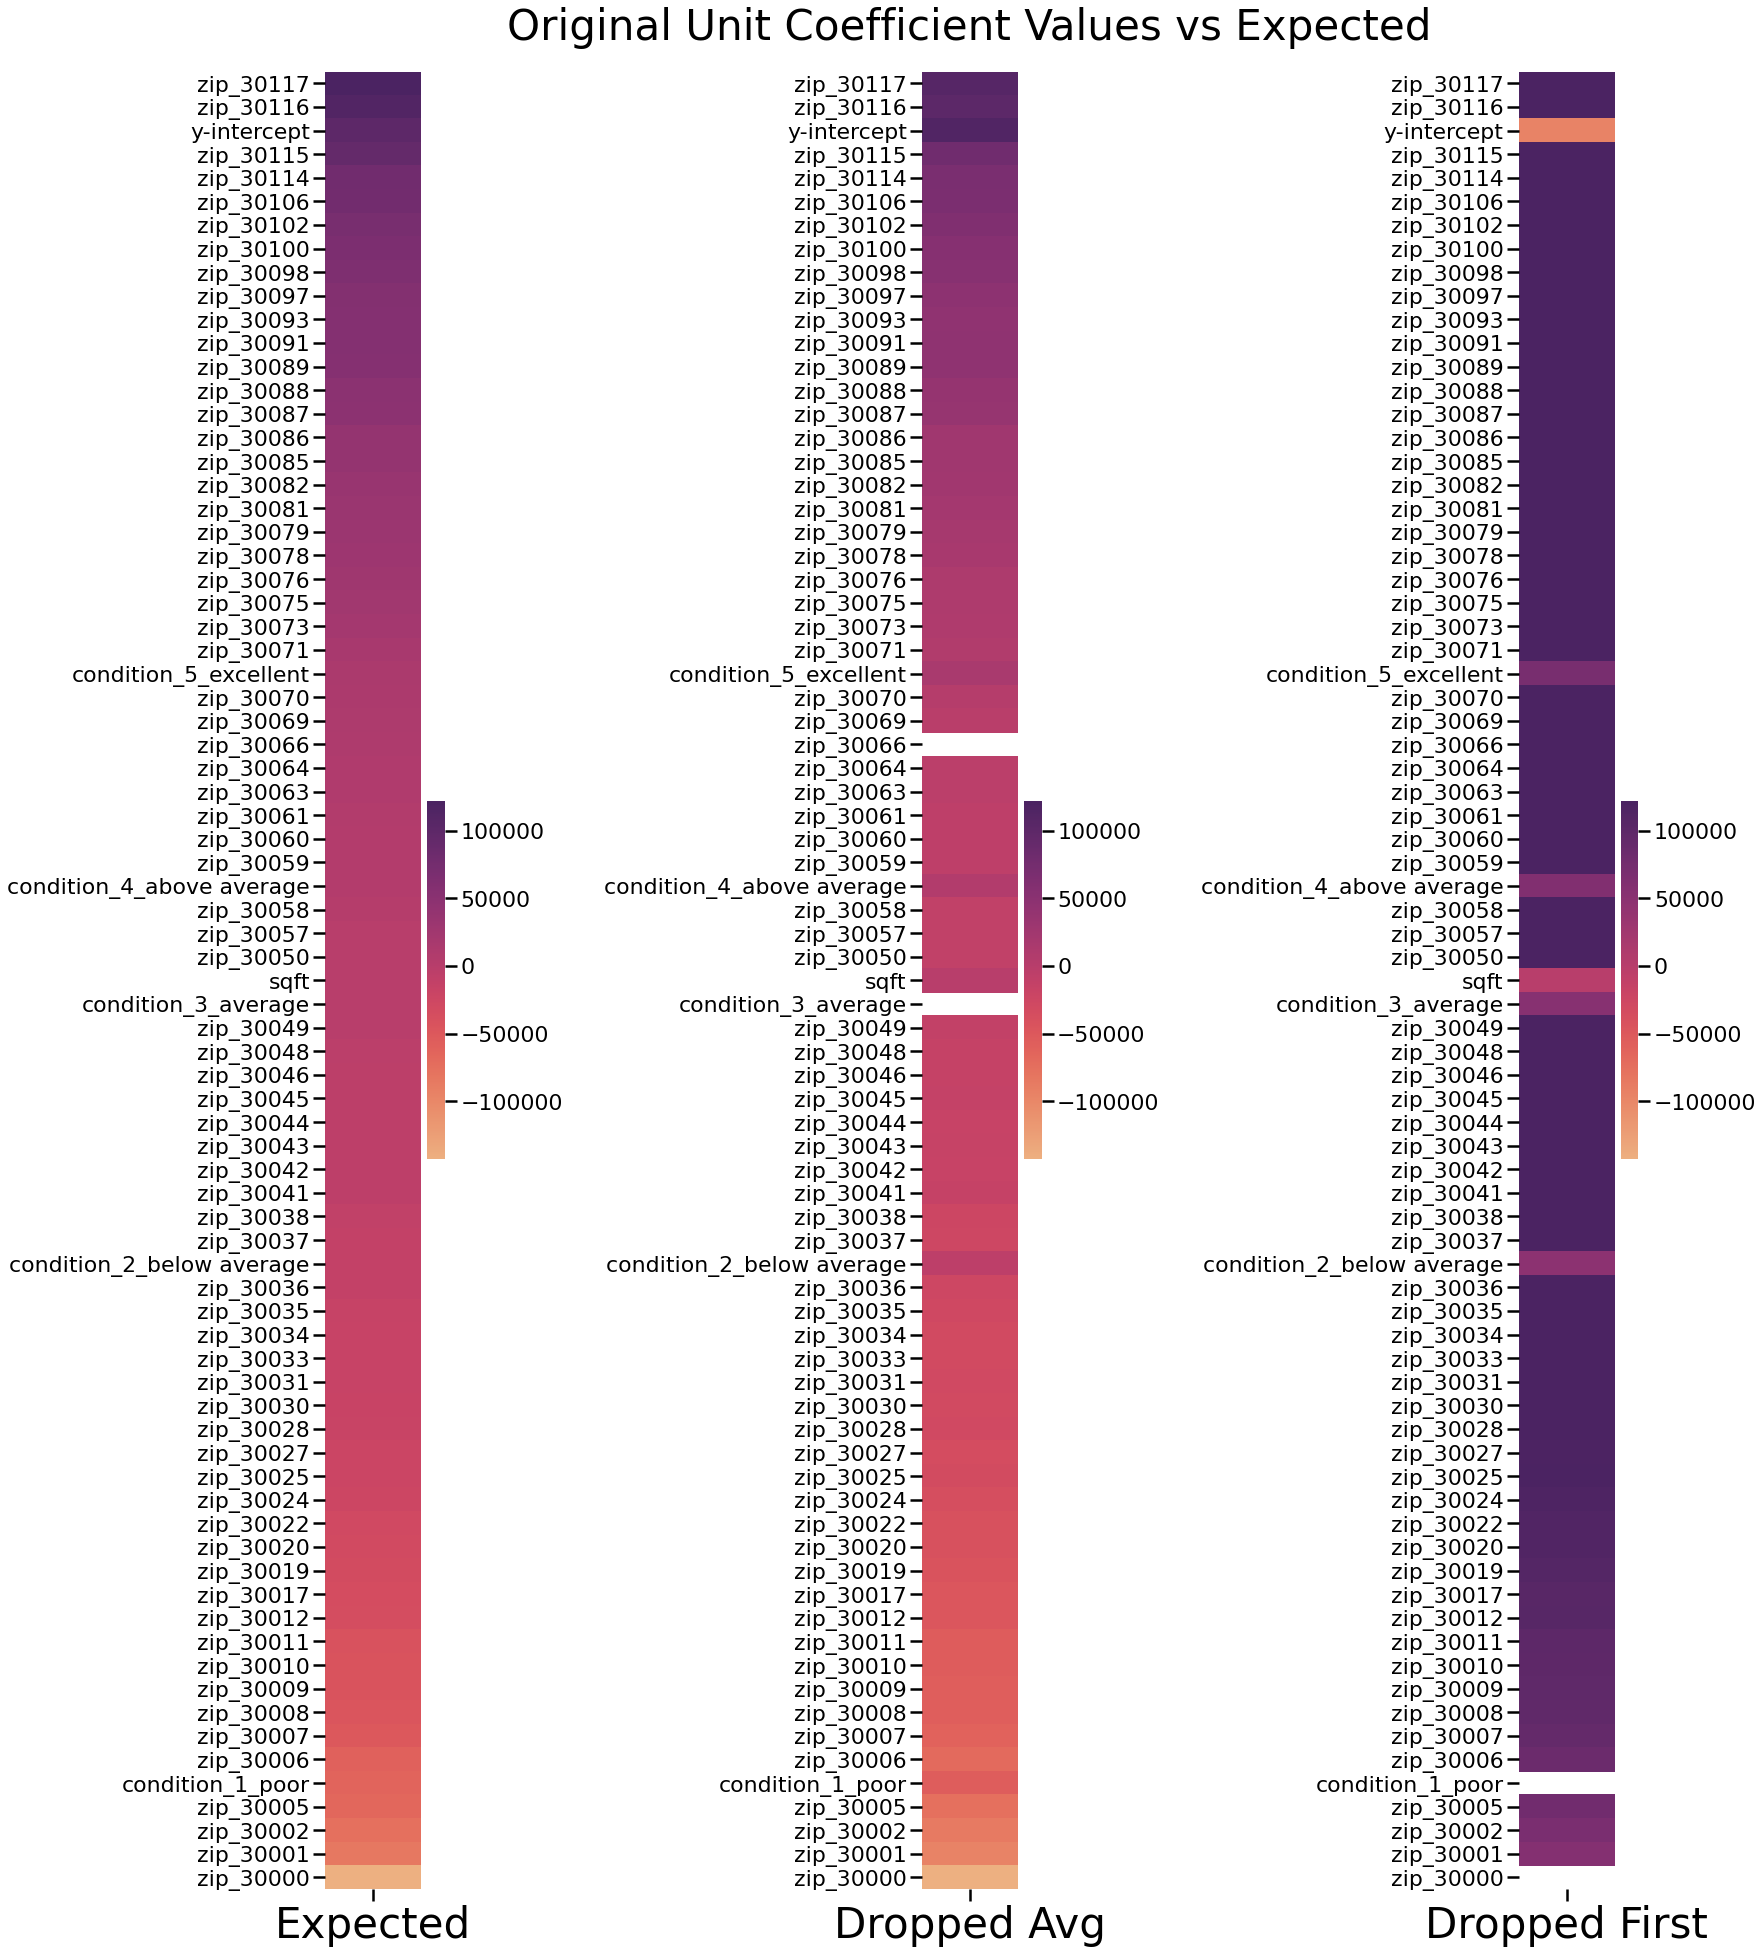

In [88]:
# filter out coefficients for models where we did NOT standardize data, and 
# did not include confounding variable (more realistic)
test_coefs = df_coefs.filter(items=[10, 11], axis=0).transpose()
test_coefs.rename(columns={10:'Dropped First', 11:'Dropped Avg'}, inplace=True)
test_coefs.drop(index='model_id', inplace=True)
test_coefs.dropna(axis=0, how='all', inplace=True)


test_coefs['Expected'] = df_ex_coefs['expected_coef']
test_coefs = test_coefs.sort_values(['Expected'], ascending=False)

sns.set_context('poster')
    
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(20, 30), ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=4)

# setting min and max values for each plot to follow the expected values, for
# ease of comparison
vmin = test_coefs[['Expected']].min()
vmax = test_coefs[['Expected']].max()

sns.heatmap(test_coefs[['Expected']], cmap='flare', ax=ax1, vmin=vmin, vmax=vmax)
sns.heatmap(test_coefs[['Dropped Avg']], cmap='flare', ax=ax2, vmin=vmin, vmax=vmax)
sns.heatmap(test_coefs[['Dropped First']], cmap='flare', ax=ax3, vmin=vmin, vmax=vmax)

for ax_f in [ax1, ax2, ax3]:
    ax_f.set_xticklabels(ax_f.get_xticklabels(), fontsize=42)

# great subplot title formatting tips used below from:
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
st = fig.suptitle("Original Unit Coefficient Values vs Expected", fontsize=42)
# shift subplots down:
st.set_y(0.90)
fig.subplots_adjust(top=0.87);

Note that in this visualization, the color scale of the test models was forced to match the expected model. We could easily calculate the expected coefficients in original units (so they should be accurate) and here we care about how accurate the coefficients are, as opposed to with standardized coefs where we cared more about the ranking order.

We can see that the model where we dropped the average column is much closed to expected. In the model where we dropped the first column, the y-intercept was too low, which cause most of the other coefficients to be too high to make up for it.

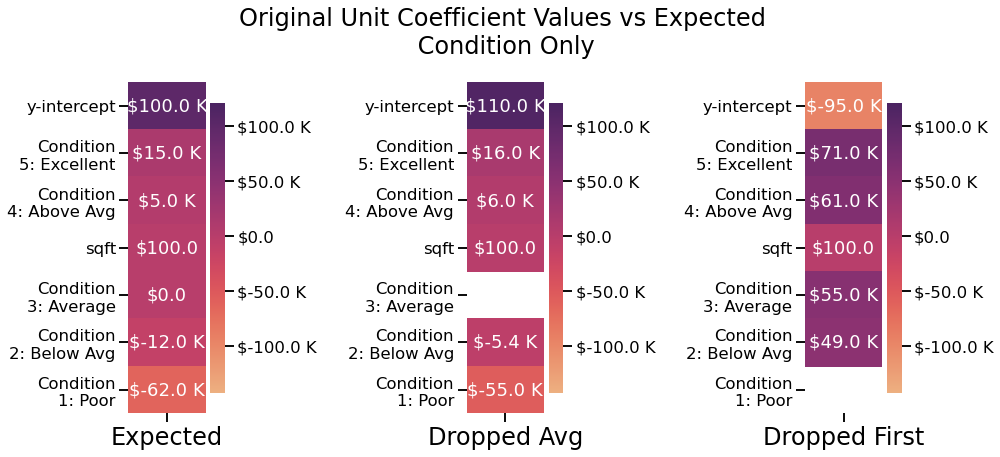

In [91]:
sns.set_context('talk')

mapper = {'condition_5_excellent': 'Condition\n5: Excellent',
          'condition_4_above average': 'Condition\n4: Above Avg',
          'condition_3_average': 'Condition\n3: Average',
          'condition_2_below average': 'Condition\n2: Below Avg',
          'condition_1_poor': 'Condition\n1: Poor',
         }

fig, [ax1, ax2, ax3] = plt.subplots(figsize=(12, 7), ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=2.5)

exp2 = test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Expected']]
exp2.rename(mapper=mapper, inplace=True)
avg2 = test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Dropped Avg']]
avg2.rename(mapper=mapper, inplace=True)
first2 = test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Dropped First']]
first2.rename(mapper=mapper, inplace=True)

sns.heatmap(exp2, cmap='flare', ax=ax1, annot=True, vmin=vmin, vmax=vmax)
sns.heatmap(avg2, cmap='flare', ax=ax2, annot=True, vmin=vmin, vmax=vmax)
sns.heatmap(first2, cmap='flare', ax=ax3, annot=True, vmin=vmin, vmax=vmax)
    
# code adapted from https://stackoverflow.com/questions/55007525/add-comma-separator-to-seaborn-heatmap-using-set-text-from-matplotlib-and-keep-d
for ax_f in [ax1, ax2, ax3]:
    for t in ax_f.texts:
        t.set_text(linregtools.currency(float(t.get_text())))
    # code adapted from https://stackoverflow.com/questions/34820239/seaborn-heatmap-colorbar-label-as-percentage
    cbar = ax_f.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(linregtools.currency)
    ax_f.set_yticklabels(ax_f.get_yticklabels(), rotation = 0)
    ax_f.set_xticklabels(ax_f.get_xticklabels(), fontsize=24)
    
# great subplot title formatting tips used below from:
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
st = fig.suptitle("Original Unit Coefficient Values vs Expected\n Condition Only", fontsize=24)
# shift subplots down:
st.set_y(0.90)
fig.subplots_adjust(top=0.75);
    


The categorical coefficients of the model where we dropped the first category are quite a bit different than what we would expect. This is primarily because the y-intercept, to which we would add each coefficient, is so different, at \\$-95K. Notice that even if we were to add the coefficient for Condition 5 - Excellent (\\$71K) to the y-intercept, we would still have a negative number! The coefficients of the zip codes as well as square feet will add up to the right price eventually so that the predicted prices would be accurate, but attempting to use the values of these coefficients to determine which variables or categories add versus detract from price would be lead to inaccuracies if we used the Dropped First model.

Although not perfect, the Dropped Average model has coefficients that are not only closer to the expected in value, but also have accurate negative and positive values. We can see that a condition of Below Average or Poor has a negative coefficient, so would detract from price.

## Summary

Although the category you choose to drop won't affect the model's prediction accuracy, it can have a significant impact on the interpretability of the model.

A linear regression model's coefficients are interpreted in the context of a baseline model that represents all variables being set to 0. When you drop a categorical variable column, it's incorporated into that baseline, so it's as if we're assuming that category value has an affect of zero, and the rest of the values which are in the model will be additive. 

If the first category label  really does represent a good 0 baseline for that category, you might be fine. However, if it actually represents a category with a negative or positive impact on the target, this can cause the y-intercept to be set lower or higher than it should be. A y-intercept that's far off from where it should be will cause other coefficients to be skewed high or low to make up for it, which can make them difficult to interpret.

If you plan to use the coefficients in your model to make accurate inferences about:
- impact on the target per predictor unit,
- or the magnitude of impact each predictor has in relation to others,

then you should carefully consider which categorical values you drop from your model. If you have a category value that naturally represents the average, consider dropping that to set its impact to 0 by incorporating it into the model's baseline. If you aren't sure which category might represent average (like in our zip code example), try dropping the category whose target mean is closest to the target mean of the whole population. It's definitely worth modeling with first as well as average categorical variables dropped, to see if you get more intuitive coefficients.

Another way to think about it is: which category does it make sense for me to use as a reference point when I'm describing all the other variables?

And of course, if your primary goal is prediction, you don't have to worry about which category value you drop!

# Extra 
- This link was one helpful explanation I found that led me to think more about this, and do some testing: https://stats.stackexchange.com/questions/344330/what-is-the-general-guideline-for-dropping-dummy-variables-in-a-regression-model
- Wow, so if you try to use the linear algebra matrix multiplication way to get the coefficients for least squares, it sounds like you actually can't use that method if you don't drop a dummy for each category, or else your matrix will be singular! https://inmachineswetrust.com/posts/drop-first-columns/ I already knew that statsmodels and scikit-learn don't use this exact method they do something else, but this helps that make more sense to me now.

## Verifying results with Statsmodels
The first model below simulates my model 1, with all predictor variables, having standardized data, and NOT dropping and categories. Interestingly, it does not get the same really high coefficients for zip codes that scikit-learn did.

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_train, X_test, y_train, y_test = preprocess(
        df, 'price', ['sqft'], cat_cols=['zip', 'condition', 'dotw'], cat_drop=None, 
        standardize=True)

X_train

In [ ]:
new_cols = [col.replace(' ', '_') for col in X_train.columns]
dict_cols = dict(zip(X_train.columns, new_cols))

X_train.rename(columns=dict_cols, inplace=True)
X_train

In [ ]:
type(y_train)

In [ ]:
y_train.reset_index(inplace=True, drop=True)

In [ ]:
df_trainall = pd.concat([y_train, X_train], axis=1)
df_trainall

In [ ]:
model = iterate_model_sm('price', X_train.columns, df_trainall)